In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

import sys
ROOT = "../../"
sys.path.append(ROOT) # Add root directory to path

from src.utils.REPClassifier import REPClassifier
from src.utils.StandardDataset import StandardDataset
from src.utils.perturbations import *

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from torchvision import datasets, transforms

In [2]:
# Step 1: Load the CIFAR-100 dataset
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [5]:
x_train = trainset.data / 255.0  # Scale pixel values to [0, 1]
y_train = np.array(trainset.targets)
x_test = testset.data / 255.0  # Scale pixel values to [0, 1]
y_test = np.array(testset.targets)

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

y_train = np.eye(100)[y_train].astype(np.float32)
y_test = np.eye(100)[y_test].astype(np.float32)

min_pixel_value = 0.0
max_pixel_value = 1.0

# Testing Round 1

In [39]:
epochs = 50
test_history = []

def display_test_history(test_history):
    for i in range(len(test_history)):
        test = test_history[i]
        num_p = len(test['perturbations'])
        io = test['include_original']
        shuffle = test['shuffle']
        baseline = test['baseline_accuracy']
        adversarial = test['adversarial_accuracy']
        adv_str = f"{adversarial[0]*100}/{adversarial[1]*100}/{adversarial[2]*100}/{adversarial[3]*100}"
        print(f"Test {i}: Perturbations ({num_p}), Original ({io}), Shuffle ({shuffle}), Baseline ({baseline*100}%), Adversarial ({adv_str}%)")

In [37]:
# Step 2: Create the REPClassifier model for testing with no perturbations
channel_widths = [3, 50, 100, 50]  
linear_sizes = [50, 100]
kernel = 3
pooling = nn.AdaptiveMaxPool2d((2, 2))

perturbation_description = []

perturbations = create_perturbations(perturbation_description)
include_original = True
shuffle = True

model = REPClassifier(
    channel_widths=channel_widths,
    linear_sizes=linear_sizes,
    kernel=kernel,
    pooling=pooling,
    perturbations=perturbations,
    include_original=include_original,
    shuffle=shuffle,
    num_classes=100,
)

In [38]:
# Step 2a: Define the loss function and the optimizer
lr = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Step 3: Create the ART classifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 28, 28),
    nb_classes=100,
)

# Step 4: Train the ART classifier
batch_size = 64
super_epochs = 10
epochs_per = 5
for epoch in range(super_epochs):
    classifier.fit(x_train, y_train, batch_size=batch_size, nb_epochs=epochs_per, verbose=False)
    train_predictions = classifier.predict(x_train)
    train_accuracy = np.sum(np.argmax(train_predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
    test_predictions = classifier.predict(x_test)
    test_accuracy = np.sum(np.argmax(test_predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print(f"Epoch {(epoch+1)*epochs_per}/{super_epochs*epochs_per} Complete! Train Acc: {train_accuracy}, Test Acc: {test_accuracy}")

Epoch 5/50 Complete! Train Acc: 0.13194, Test Acc: 0.1309
Epoch 10/50 Complete! Train Acc: 0.18138, Test Acc: 0.1764
Epoch 15/50 Complete! Train Acc: 0.20782, Test Acc: 0.1989
Epoch 20/50 Complete! Train Acc: 0.23204, Test Acc: 0.2253
Epoch 25/50 Complete! Train Acc: 0.25606, Test Acc: 0.245
Epoch 30/50 Complete! Train Acc: 0.26944, Test Acc: 0.2532
Epoch 35/50 Complete! Train Acc: 0.28556, Test Acc: 0.2689
Epoch 40/50 Complete! Train Acc: 0.30706, Test Acc: 0.2911
Epoch 45/50 Complete! Train Acc: 0.31694, Test Acc: 0.2961
Epoch 50/50 Complete! Train Acc: 0.33524, Test Acc: 0.3082


In [40]:
# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
baseline_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(baseline_accuracy * 100))

# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv1 = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv1)
adversarial_accuracy1 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples (epsilon = 0.1): {}%".format(adversarial_accuracy1 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv2 = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv2)
adversarial_accuracy2 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples (epsilon = 0.2): {}%".format(adversarial_accuracy2 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.3)
x_test_adv3 = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv3)
adversarial_accuracy3 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples (epsilon = 0.3): {}%".format(adversarial_accuracy3 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.5)
x_test_adv4 = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv4)
adversarial_accuracy4 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples (epsilon = 0.5): {}%".format(adversarial_accuracy4 * 100))

test_history.append({'channel_widths': channel_widths,
                    'linear_sizes': linear_sizes,
                    'kernel': kernel,
                    'pooling': pooling,
                    'perturbations': perturbation_description,
                    'include_original': include_original,
                    'shuffle': shuffle,
                    'loss': criterion,
                    'lr': lr,
                    'batch_size': batch_size,
                    'epochs': epochs,
                    'baseline_accuracy': baseline_accuracy,
                    'adversarial_accuracy': [adversarial_accuracy1, adversarial_accuracy2, adversarial_accuracy3, adversarial_accuracy4]})

Accuracy on benign test examples: 30.819999999999997%
Accuracy on adversarial test examples (epsilon = 0.1): 3.38%
Accuracy on adversarial test examples (epsilon = 0.2): 1.63%
Accuracy on adversarial test examples (epsilon = 0.3): 1.3299999999999998%
Accuracy on adversarial test examples (epsilon = 0.5): 0.83%


In [45]:
display_test_history(test_history)

Test 0: Perturbations (0), Original (True), Shuffle (True), Baseline (30.819999999999997%), Adversarial (3.38/1.63/1.3299999999999998/0.83%)


In [ ]:
### CREATE PERTURBATION TESTS ###
gaussian_perturbation1 = [["Gaussian", 0.1]]
gaussian_perturbation2 = [["Gaussian", 0.2]]
laplacian_perturbation1 = [["Laplacian", 0.1]]
laplacian_perturbation2 = [["Laplacian", 0.2]]
l1_norm_perturbation = [["Lp-norm", 1, 1]]
l2_norm_perturbation = [["Lp-norm", 1, 2]]
l3_norm_perturbation = [["Lp-norm", 1, 3]]
l4_norm_perturbation = [["Lp-norm", 1, 4]]
l5_norm_perturbation = [["Lp-norm", 1, 5]]
linf_norm_perturbation = [["Lp-norm", 1, float('inf')]]

gaussian_laplacian1 = [["Gaussian", 0.1], ["Laplacian", 0.1]]
gaussian_laplacian2 = [["Gaussian", 0.2], ["Laplacian", 0.2]]
multi_lp = [["Lp-norm", 1, 1], ["Lp-norm", 1, 2], ["Lp-norm", 1, 3], ["Lp-norm", 1, 4], ["Lp-norm", 1, 5], ["Lp-norm", 1, float('inf')]]
gaussian_laplacian_l2_norm1 = [["Gaussian", 0.1], ["Laplacian", 0.1], ["Lp-norm", 1, 2]]
gaussian_laplacian_l2_norm2 = [["Gaussian", 0.2], ["Laplacian", 0.2], ["Lp-norm", 1, 2]]
gaussian_laplacian_l4_norm1 = [["Gaussian", 0.1], ["Laplacian", 0.1], ["Lp-norm", 1, 4]]
gaussian_laplacian_l4_norm2 = [["Gaussian", 0.2], ["Laplacian", 0.2], ["Lp-norm", 1, 4]]
every_perturbation = [["Gaussian", 0.1], ["Laplacian", 0.1], ["Gaussian", 0.2], ["Laplacian", 0.2],
                     ["Lp-norm", 1, 1], ["Lp-norm", 1, 2], ["Lp-norm", 1, 3], ["Lp-norm", 1, 4], ["Lp-norm", 1, 5], ["Lp-norm", 1, float('inf')]]

all_perturbations = [gaussian_perturbation1, gaussian_perturbation2, laplacian_perturbation1, laplacian_perturbation2,
                     l1_norm_perturbation, l2_norm_perturbation, l3_norm_perturbation, l4_norm_perturbation, l5_norm_perturbation, linf_norm_perturbation,
                     gaussian_laplacian1, gaussian_laplacian2, 
                     multi_lp, gaussian_laplacian_l2_norm1, gaussian_laplacian_l2_norm2, gaussian_laplacian_l4_norm1, gaussian_laplacian_l4_norm2,
                     every_perturbation]

In [50]:
channel_widths = [3, 50, 100, 50]  
linear_sizes = [50, 100]
kernel = 3
pooling = nn.AdaptiveMaxPool2d((2, 2))
lr = 0.0001
criterion = nn.CrossEntropyLoss()

for perturbation_description in all_perturbations:
    perturbations = create_perturbations(perturbation_description)
    include_original = False
    shuffle = True

    model = REPClassifier(
        channel_widths=channel_widths,
        linear_sizes=linear_sizes,
        kernel=kernel,
        pooling=pooling,
        perturbations=perturbations,
        include_original=include_original,
        shuffle=shuffle,
        num_classes=100,
    )
    
    optimizer = optim.Adam(model.parameters(), lr=lr)

    classifier = PyTorchClassifier(
        model=model,
        clip_values=(min_pixel_value, max_pixel_value),
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 28, 28),
        nb_classes=100,
    )

    batch_size = 64
    super_epochs = 5
    epochs_per = 10
    print(f"Training model with perturbations:")
    print(perturbation_description)
    training_start = time.time()
    for epoch in range(super_epochs):
        classifier.fit(x_train, y_train, batch_size=batch_size, nb_epochs=epochs_per, verbose=False)
        with torch.no_grad():
            train_predictions = classifier.predict(x_train)
            train_accuracy = np.sum(np.argmax(train_predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
            test_predictions = classifier.predict(x_test)
            test_accuracy = np.sum(np.argmax(test_predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
            print(f"Epoch {(epoch+1)*epochs_per}/{super_epochs*epochs_per} Complete After {int(time.time() - training_start)}s! Train Acc: {train_accuracy}, Test Acc: {test_accuracy}")
    
    # Step 5: Evaluate the ART classifier on benign test examples
    predictions = classifier.predict(x_test)
    baseline_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print("Accuracy on benign test examples: {}%".format(baseline_accuracy * 100))

    # Step 6: Generate adversarial test examples
    attack = FastGradientMethod(estimator=classifier, eps=0.1)
    x_test_adv1 = attack.generate(x=x_test)
    predictions = classifier.predict(x_test_adv1)
    adversarial_accuracy1 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.1): {}%".format(adversarial_accuracy1 * 100))

    attack = FastGradientMethod(estimator=classifier, eps=0.2)
    x_test_adv2 = attack.generate(x=x_test)
    predictions = classifier.predict(x_test_adv2)
    adversarial_accuracy2 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.2): {}%".format(adversarial_accuracy2 * 100))

    attack = FastGradientMethod(estimator=classifier, eps=0.3)
    x_test_adv3 = attack.generate(x=x_test)
    predictions = classifier.predict(x_test_adv3)
    adversarial_accuracy3 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.3): {}%".format(adversarial_accuracy3 * 100))

    attack = FastGradientMethod(estimator=classifier, eps=0.5)
    x_test_adv4 = attack.generate(x=x_test)
    predictions = classifier.predict(x_test_adv4)
    adversarial_accuracy4 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.5): {}%".format(adversarial_accuracy4 * 100))

    test_history.append({'channel_widths': channel_widths,
                        'linear_sizes': linear_sizes,
                        'kernel': kernel,
                        'pooling': pooling,
                        'perturbations': perturbation_description,
                        'include_original': include_original,
                        'shuffle': shuffle,
                        'loss': criterion,
                        'lr': lr,
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'baseline_accuracy': baseline_accuracy,
                        'adversarial_accuracy': [adversarial_accuracy1, adversarial_accuracy2, adversarial_accuracy3, adversarial_accuracy4]})

Training model with perturbations:
[['Gaussian', 0.1]]
Epoch 10/50 Complete After 62s! Train Acc: 0.18348, Test Acc: 0.182
Epoch 20/50 Complete After 126s! Train Acc: 0.22854, Test Acc: 0.2194
Epoch 30/50 Complete After 188s! Train Acc: 0.2616, Test Acc: 0.2499
Epoch 40/50 Complete After 252s! Train Acc: 0.29568, Test Acc: 0.2739
Epoch 50/50 Complete After 315s! Train Acc: 0.3195, Test Acc: 0.2968
Accuracy on benign test examples: 29.69%
Accuracy on adversarial test examples (epsilon = 0.1): 4.91%
Accuracy on adversarial test examples (epsilon = 0.2): 2.16%
Accuracy on adversarial test examples (epsilon = 0.3): 1.25%
Accuracy on adversarial test examples (epsilon = 0.5): 0.88%
Training model with perturbations:
[['Gaussian', 0.2]]
Epoch 10/50 Complete After 63s! Train Acc: 0.164, Test Acc: 0.1629
Epoch 20/50 Complete After 127s! Train Acc: 0.2009, Test Acc: 0.191
Epoch 30/50 Complete After 191s! Train Acc: 0.22712, Test Acc: 0.2171
Epoch 40/50 Complete After 255s! Train Acc: 0.25486, T

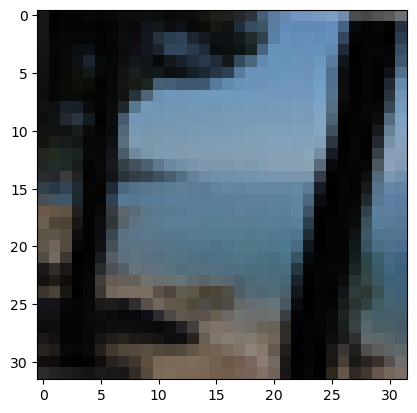

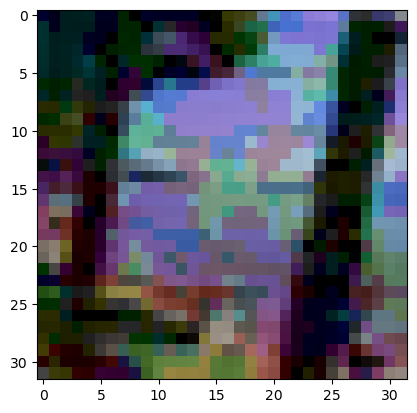

In [58]:
idx = 10

plt.figure()
plt.imshow(np.transpose(x_test[idx], (1, 2, 0)))
plt.show()
# print(np.argmax(classifier.predict(x_test[idx]), axis=1))

plt.figure()
plt.imshow(np.transpose(x_test_adv1[idx], (1, 2, 0)))
plt.show()
# print(np.argmax(classifier.predict(x_test_adv2[idx]), axis=1))


In [59]:
display_test_history(test_history)

Test 0: Perturbations (0), Original (True), Shuffle (True), Baseline (30.819999999999997%), Adversarial (3.38/1.63/1.3299999999999998/0.83%)
Test 1: Perturbations (1), Original (False), Shuffle (True), Baseline (29.69%), Adversarial (4.91/2.16/1.25/0.88%)
Test 2: Perturbations (1), Original (False), Shuffle (True), Baseline (26.38%), Adversarial (7.870000000000001/3.1199999999999997/1.92/1.3299999999999998%)
Test 3: Perturbations (1), Original (False), Shuffle (True), Baseline (26.82%), Adversarial (5.83/2.65/1.71/1.0699999999999998%)
Test 4: Perturbations (1), Original (False), Shuffle (True), Baseline (22.54%), Adversarial (9.06/3.7600000000000002/2.2800000000000002/1.27%)
Test 5: Perturbations (1), Original (False), Shuffle (True), Baseline (31.7%), Adversarial (3.44/1.67/1.27/0.7000000000000001%)
Test 6: Perturbations (1), Original (False), Shuffle (True), Baseline (32.34%), Adversarial (3.32/1.79/1.29/0.9299999999999999%)
Test 7: Perturbations (1), Original (False), Shuffle (True)

In [60]:
best_i = 0
accuracy = 0
eps = 3
for i in range(len(test_history)):
    if test_history[i]['adversarial_accuracy'][eps] > accuracy:
        best_i = i
        accuracy = test_history[i]['adversarial_accuracy'][eps]
print(test_history[best_i])

{'channel_widths': [3, 50, 100, 50], 'linear_sizes': [50, 100], 'kernel': 3, 'pooling': AdaptiveMaxPool2d(output_size=(2, 2)), 'perturbations': [['Lp-norm', 1, inf]], 'include_original': False, 'shuffle': True, 'loss': CrossEntropyLoss(), 'lr': 0.0001, 'batch_size': 64, 'epochs': 50, 'baseline_accuracy': 0.2448, 'adversarial_accuracy': [0.0879, 0.0369, 0.0226, 0.0134]}


In [61]:
import csv

def save_to_csv(data, filename):
    if not data:
        return

    # Extract the keys from the first dictionary as headers
    headers = list(data[0].keys())

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)

        # Write the headers
        writer.writeheader()

        # Write each dictionary as a row in the CSV file
        for item in data:
            writer.writerow(item)

    print(f"Data saved to {filename} successfully.")

save_to_csv(test_history, ROOT + "notebooks/experiment_log/cifar_100_round_1_training_results.csv")

Data saved to ../../notebooks/experiment_log/cifar_100_round_1_training_results.csv successfully.


# Testing Round 2

In [20]:
perturbation_tests = [
    # [],
    # [["Gaussian", 0.025]],
    # [["Gaussian", 0.05]],
    [[["Gaussian", 0.05], ["ContrastBrightness", 0.9, 0.9]]],
    [[["Gaussian", 0.05], ["RotationFlip", 0.3]]],
    [[["Gaussian", 0.05], ["SaltPepper", 0.05]]],
    [["Laplacian", 0.025]],
    [["Laplacian", 0.05]],
    [[["Laplacian", 0.05], ["ContrastBrightness", 0.9, 0.9]]],
    [[["Laplacian", 0.05], ["RotationFlip", 0.3]]],
    [[["Laplacian", 0.05], ["SaltPepper", 0.05]]],
    [["Lp-norm", 0.5, 1]],
    [[["Lp-norm", 0.5, 1], ["ContrastBrightness", 0.9, 0.9]]],
    [[["Lp-norm", 0.5, 1], ["RotationFlip", 0.3]]],
    [[["Lp-norm", 0.5, 1], ["SaltPepper", 0.05]]],
    [["Lp-norm", 0.5, 2]],
    [["Lp-norm", 0.5, 3]],
    [["Lp-norm", 0.5, 4]],
    [["Lp-norm", 0.5, float('inf')]],
    [["ContrastBrightness", 0.9, 0.9]],
    [["RotationFlip", 0.3]],
    [["SaltPepper", 0.05]],
    [["Gaussian", 0.05], ["Laplacian", 0.05]],
    [[["Gaussian", 0.05], ["Laplacian", 0.05]]],
    [["Gaussian", 0.05], ["Lp-norm", 0.5, 1]],
    [["Laplacian", 0.05], ["Lp-norm", 0.5, 1]],
    [["Lp-norm", 0.5, 1], ["Lp-norm", 0.5, 2]],
    [["Gaussian", 0.05], ["Laplacian", 0.05], ["Lp-norm", 0.5, 1]],
    [["Gaussian", 0.05], [["Laplacian", 0.05], ["SaltPepper", 0.05]]],
    [["Gaussian", 0.05], [["Lp-norm", 0.5, 1], ["ContrastBrightness", 0.9, 0.9]]],
    [["Laplacian", 0.05], [["Lp-norm", 0.5, 1], ["RotationFlip", 0.3]]],
]

In [21]:
test_history = []

def display_test_history(test_history):
    for i in range(len(test_history)):
        test = test_history[i]
        num_p = len(test['perturbations'])
        io = test['include_original']
        shuffle = test['shuffle']
        training_time = test['training_time']
        baseline = test['baseline_accuracy']
        adversarial = test['adversarial_accuracy']
        adv_str = f"{adversarial[0]*100}/{adversarial[1]*100}/{adversarial[2]*100}/{adversarial[3]*100}"
        print(f"Test {i}: Perturbations ({num_p}), Original ({io}), Shuffle ({shuffle}), Training Time ({training_time}s), Baseline ({baseline*100}%), Adversarial ({adv_str}%)")

In [22]:
channel_widths = [3, 50, 100, 50]  
linear_sizes = [50, 100]
kernel = 3
pooling = nn.AdaptiveMaxPool2d((2, 2))
lr = 0.0001
criterion = nn.CrossEntropyLoss()

for perturbation_description in perturbation_tests:
    perturbations = create_perturbations(perturbation_description)
    include_original = perturbation_description == []
    shuffle = True

    model = REPClassifier(
        channel_widths=channel_widths,
        linear_sizes=linear_sizes,
        kernel=kernel,
        pooling=pooling,
        perturbations=perturbations,
        include_original=include_original,
        shuffle=shuffle,
        num_classes=100,
    )
    
    optimizer = optim.Adam(model.parameters(), lr=lr)

    classifier = PyTorchClassifier(
        model=model,
        clip_values=(min_pixel_value, max_pixel_value),
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 32, 32),
        nb_classes=100,
    )

    batch_size = 64
    super_epochs = 10
    epochs_per = 10
    print(f"Training model with perturbations:")
    print(perturbation_description)
    training_start = time.time()
    for epoch in range(super_epochs):
        classifier.fit(x_train, y_train, batch_size=batch_size, nb_epochs=epochs_per, verbose=False)
        with torch.no_grad():
            train_predictions = classifier.predict(x_train)
            train_accuracy = np.sum(np.argmax(train_predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
            test_predictions = classifier.predict(x_test)
            test_accuracy = np.sum(np.argmax(test_predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
            print(f"Epoch {(epoch+1)*epochs_per}/{super_epochs*epochs_per} Complete After {int(time.time() - training_start)}s! Train Acc: {train_accuracy}, Test Acc: {test_accuracy}")
    total_time = time.time() - training_start

    # Step 5: Evaluate the ART classifier on benign test examples
    predictions = classifier.predict(x_test)
    baseline_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print("Accuracy on benign test examples: {}%".format(baseline_accuracy * 100))

    # Step 6: Generate adversarial test examples
    attack = FastGradientMethod(estimator=classifier, eps=0.025)
    x_test_adv1 = attack.generate(x=x_test)
    predictions = classifier.predict(x_test_adv1)
    adversarial_accuracy1 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.0.025): {}%".format(adversarial_accuracy1 * 100))

    attack = FastGradientMethod(estimator=classifier, eps=0.05)
    x_test_adv2 = attack.generate(x=x_test)
    predictions = classifier.predict(x_test_adv2)
    adversarial_accuracy2 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.05): {}%".format(adversarial_accuracy2 * 100))

    attack = FastGradientMethod(estimator=classifier, eps=0.075)
    x_test_adv3 = attack.generate(x=x_test)
    predictions = classifier.predict(x_test_adv3)
    adversarial_accuracy3 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.075): {}%".format(adversarial_accuracy3 * 100))

    attack = FastGradientMethod(estimator=classifier, eps=0.1)
    x_test_adv4 = attack.generate(x=x_test)
    predictions = classifier.predict(x_test_adv4)
    adversarial_accuracy4 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.1): {}%".format(adversarial_accuracy4 * 100))

    test_history.append({'channel_widths': channel_widths,
                        'linear_sizes': linear_sizes,
                        'kernel': kernel,
                        'pooling': pooling,
                        'perturbations': perturbation_description,
                        'include_original': include_original,
                        'shuffle': shuffle,
                        'loss': criterion,
                        'lr': lr,
                        'batch_size': batch_size,
                        'epochs': int(super_epochs*epochs_per),
                        'training_time': total_time,
                        'baseline_accuracy': baseline_accuracy,
                        'adversarial_accuracy': [adversarial_accuracy1, adversarial_accuracy2, adversarial_accuracy3, adversarial_accuracy4]})

Training model with perturbations:
[[['Gaussian', 0.05], ['ContrastBrightness', 0.9, 0.9]]]
Epoch 10/100 Complete After 53s! Train Acc: 0.06036, Test Acc: 0.0611
Epoch 20/100 Complete After 107s! Train Acc: 0.09602, Test Acc: 0.1031
Epoch 30/100 Complete After 161s! Train Acc: 0.12176, Test Acc: 0.1243
Epoch 40/100 Complete After 215s! Train Acc: 0.14082, Test Acc: 0.1438
Epoch 50/100 Complete After 270s! Train Acc: 0.16166, Test Acc: 0.1649
Epoch 60/100 Complete After 325s! Train Acc: 0.17782, Test Acc: 0.1713
Epoch 70/100 Complete After 381s! Train Acc: 0.18964, Test Acc: 0.1919
Epoch 80/100 Complete After 436s! Train Acc: 0.20538, Test Acc: 0.1937
Epoch 90/100 Complete After 491s! Train Acc: 0.21622, Test Acc: 0.1929
Epoch 100/100 Complete After 547s! Train Acc: 0.2379, Test Acc: 0.2216
Accuracy on benign test examples: 22.53%
Accuracy on adversarial test examples (epsilon = 0.0.025): 15.690000000000001%
Accuracy on adversarial test examples (epsilon = 0.05): 12.35%
Accuracy on adve

In [23]:
display_test_history(test_history=test_history)

Test 0: Perturbations (1), Original (False), Shuffle (True), Training Time (547.7024054527283s), Baseline (22.53%), Adversarial (15.690000000000001/12.35/10.96/9.54%)
Test 1: Perturbations (1), Original (False), Shuffle (True), Training Time (544.7114560604095s), Baseline (33.410000000000004%), Adversarial (21.41/12.47/7.8/5.27%)
Test 2: Perturbations (1), Original (False), Shuffle (True), Training Time (554.6939740180969s), Baseline (32.72%), Adversarial (22.05/13.34/9.21/6.94%)
Test 3: Perturbations (1), Original (False), Shuffle (True), Training Time (728.2032270431519s), Baseline (37.21%), Adversarial (12.22/7.140000000000001/5.1/3.6799999999999997%)
Test 4: Perturbations (1), Original (False), Shuffle (True), Training Time (729.4358289241791s), Baseline (35.370000000000005%), Adversarial (16.09/9.27/6.2700000000000005/4.4799999999999995%)
Test 5: Perturbations (1), Original (False), Shuffle (True), Training Time (750.4908287525177s), Baseline (21.11%), Adversarial (17.04/11.77/10.

In [24]:
import csv

def save_to_csv(data, filename):
    if not data:
        return

    # Extract the keys from the first dictionary as headers
    headers = list(data[0].keys())

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)

        # Write the headers
        writer.writeheader()

        # Write each dictionary as a row in the CSV file
        for item in data:
            writer.writerow(item)

    print(f"Data saved to {filename} successfully.")

save_to_csv(test_history, ROOT + "notebooks/experiment_log/cifar_100_round_2_training_results.csv")

Data saved to ../../notebooks/experiment_log/cifar_100_round_2_training_results.csv successfully.
